## Mathematical Principles in Pattern Recognition (2016/2017)
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bA}{\mathbf{A}}$
$\newcommand{\bQ}{\mathbf{Q}}$
$\newcommand{\bR}{\mathbf{R}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bsigma}{\boldsymbol{\sigma}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bpi}{\boldsymbol{\pi}}$

# Lab 4

In the computer labs we will work with the Python programming language within a Jupyter notebook. Each week a new notebook is made available that contains the exercises that are to be handed-in. 

* You are expected to work in pairs
* Use Python 2.7!
* Only one of each pair has to submit on blackboard. Make sure that you add the student ID of your partner in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name 1]_[last name 2].ipynb", for example "Lab2_Bongers_Versteeg.ipynb". 
* Please make sure your code will run without problems!

Feel free ask any questions during the computer lab sessions, or email the TA, Elise (e.e.vanderpol@uva.nl).

**The due date for the labs is Friday, Oct 13 at 15:00**

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1 Bayesian regression
So far we have been using the frequentist approach to regression problems, where we find point-wise estimates of the parameters of a model. In this lab we make a detour to the Bayesian viewpoint with a Bayesian linear regression using polynomial basis functions. First we will generate some noisy data, and use an appropriate prior with polynomial basis functions to find the posterior and predictive distributions. 

Note: To stay in line with the notation in Bishop chapter 3.3, we will notate target variable of the regression as $t$ and the features as $x$ throughout this exercise.

### 1.1 Generate data
**[10 points]**Create a function `generate_data(n)` that returns $N$ samples from a noisy sinusoidal model: 
$$
   t = y(x) + \epsilon = \sin(2\pi \ x) + \epsilon 
$$
with
$$
   x \sim \mathcal{U}(0,1) \\
   \epsilon \sim \mathcal{N}(0,0.2)
$$
where $\mathcal{U}(a,b)$ denotes the uniform distribution between $a$ and $b$, and $\mathcal{N}$ the usual Gaussian distribution. 

Make a scatterplot of features $x$ versus targets $t$ with $N = 20$ samples.

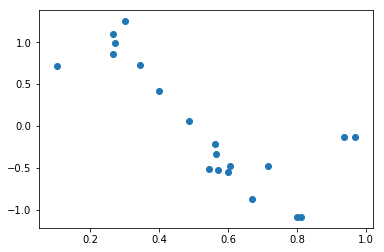

In [23]:
def generate_data(n):
    result = []
    x_list = []
    for i in range(n):
        x = random_sample()
        e = random.normal(0, 0.2)
        new_sample = sin(2*pi*x) + e
        result.append(new_sample)
        x_list.append(x)
    return result, x_list
        

n = 20
data,x  = generate_data(n)
plt.scatter(x, data)

The linear regression model we will use here is in terms of polynomial basisfunction, $\phi_i = x^i$, such that we have 
$$
    y(\bx) = \sum_{i=0}^{M-1} w_i \phi_i
$$
where $w_i$ are the weight parameters and $M$ is the total number of model parameters. I.e. for $M = 3$ we have $3$ basisfunctions $\phi_0 = 1$; $\ \phi_1(x) = x$; and $\phi_2(x) = x^2$.
### 1.2 Design matrix
**[10 points]**
Write a function `designmatrix_poly(x,m)` that for a given vector of data-samples $\bx$ and $M$ returns the designmatrix. 

In [45]:
def designmatrix_poly(x,m):
    result_matrix = matrix(ones((size(x), m)))
    for i in range(len(x)):
        for j in range(1,m):
            result_matrix[i,j] = x[i] ** j
    return result_matrix


### 1.3 Prior samples
**[10 points]** First consider the prior distribution on the model parameters $\bw$. Analogous to Bishop chapter 3.3.1, we will use an isotropic Gaussian with zero mean, 
$$
p(\bw) = \mathcal{N}(\bw \mid \mathbf{0}, \alpha^{-1} \bI)
$$
where the $\alpha$ hyperparameter indicates its precision and $\bw$ are the weights for basis-functions $\phi_i(x) = x^i$. Draw a few samples from this prior distribution with fixed $\alpha = 2$ for $M = 4$ and plot the resulting model in a few plots (in the same range as the simulated data will have).

In [80]:
alpha = 2
M = 4
mu = [0,0,0,0]
sigma = alpha ** -1 * identity(M)
w = []
nr_samples = 10

for _ in range(nr_samples):
    w.append(random.multivariate_normal(mu, sigma))

print(w)

# ik snap niet hoe ik het moet plotten

[array([-0.20610746, -1.62208323,  0.76246788, -1.42925417]), array([ 0.32797169,  0.81350537,  1.5126038 , -0.11732051]), array([ 0.34480882,  0.23383479, -0.38053127,  0.35167894]), array([ 0.16366228,  0.21936665, -1.25522702,  0.19715494]), array([-0.37605244,  0.80767163, -0.21150004, -1.16440502]), array([ 0.66475806, -0.81461265, -1.07355783,  1.11062792]), array([-1.15909388, -0.44561955, -0.44866884, -1.40648592]), array([-0.54214747,  0.67419067,  0.81615743, -0.91520975]), array([-0.17279684, -0.43079546,  0.02291546, -0.17747163]), array([ 0.3295354 , -0.41370439,  0.68056325, -1.2139225 ])]


### 1.4 Posterior distribution
**[35 points]** The corresponding posterior distribution is a Gaussian defined by parameters
$$
    \bm_N = \beta \bS_N \bPhi^T \bt \\
    \bS_N^{-1} = \alpha \bI + \beta \bPhi^T \bPhi
$$
where $\bm_N$ and $\bS_N$ are the mean and covariance of the posterior, $\bPhi$ is the designmatrix and $\beta$ is a noise precision parameter that we shall consider to be a given constant, set to $\beta = (1\ /\ 0.2)^{2}$.

Write a function `compute_posterior` that returns the $\bm_N$ and $\bS_N$ for given input $\alpha$, $\beta$, $M$, $\bx$, $\bt$ that uses `designmatrix_poly` from above. 

Generate four datasets with $N = \{1, 2, 4, 25\}$ 
and use each of those to plot 5 samples of the posterior, as you did earlier with the prior. (Hint: compare to Bishop figure 3.9) What is the overall trend?

In [132]:

def compute_posterior(n):
    t, x = generate_data(n)
    Phi = designmatrix_poly(x,M)
    S_1 = alpha*identity(M) + beta*Phi.T*Phi
    m_1 = beta*inv(S_1)*Phi.T*matrix(t).T
    return S_1, m_1

    
N = [1, 2, 4, 25]
M = 4
alpha = 2
beta = (1/0.2) ** 2
N = [1,2,4,25]
m = []
S = []

for n in N:
    S_1, m_1 = compute_posterior(n)
    S.append(S_1)
    m.append(m_1)
    
# fucking numpy bullshit
# de volgende regel werkt niet dus ik heb het vervangen
# random.multivariate_normal(m[-1], S[-1])
sample =[random.multivariate_normal(array(m[-1].T)[0], S[-1]) for _ in range(5)]   
# ik snap niet hoe ik het moet plotten

[answer here]

### 1.5 Predictive distribution
**[35 points]** The predictive distribution of a new target $t$ for new input feature $x$ is in this case given by the following equations (Bishop 3.58 and 3.59):
$$
p(t \mid \bx, \bt, \alpha, \beta) = \mathcal{N}(t \mid \bm_N^T \phi(\bx), \sigma_N^2(\bx)) \\
\sigma_N^2(x) = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx)
$$

Create a function `compute_predictive` that returns the parameters of the predictive distribution. Make use of your `compute_posterior` implementation!

Using the four datasets from 1.5, plot the four resulting Gaussian predictive distributions $p(t \mid x)$ for one particular random new $x$ in the same figure. How does it change with increasing $N$? Compare it with your figure from 1.4 or figure 3.8 in Bishop.

In [ ]:
def compute_predictive():
    
    #?

[answer here]